<h1>MLP Predictor for stock data</h1>

<h3>Author: Danilo Filippo Reiszel Pereira</h3>
<strong>Univesidade Federal do Rio de Janeiro</strong>

<p>This notebook contains the creation a Multi-layer Perceptron model to predict D+1 closing prices of stocks</p>

In [1]:
import sys, os
sys.path.append('../src')
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralstocks.dataacquisition import *
from neuralstocks.plots import *
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

%matplotlib inline

Using TensorFlow backend.


<h3>Global Params</h3>

Setting global params such as directory of data, save directories and plot params

In [2]:
dataPath = '../../data'
assetType = 'stocks'
asset = 'PETR4'
frequency = 'diario'
filePath = dataPath + '/' + assetType + '/' + asset + '/' + frequency + '/' + asset + '.CSV'

pathPETR4 = '../../data/stocks/PETR4/diario/PETR4.CSV'
pathIBOV = '../../data/indexes/IBOV/diario/IBOV.CSV'
pathUSDBRL = '../../data/forex/USDBRL/diario/USDBRL.CSV'
pathEURBRL = '../../data/forex/EURBRL/diario/EURBRL.CSV'

decomposeModel = 'additive'

saveVarDir = './Variables'
if not os.path.exists(saveVarDir):
    os.makedirs(saveVarDir)
    print('saveVarDir created')
else:
    print('saveVarDir already exists!')
saveFigDir = './Figures'
if not os.path.exists(saveFigDir):
    os.makedirs(saveFigDir)
    print('saveFigDir created')
else:
    print('saveFigDir already exists!')
saveFormat = 'png'

plt.rcParams['font.weight'] = 'bold'
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

saveVarDir already exists!
saveFigDir already exists!


<h3>Data Acquisition and Preprocessing</h3>

Gathers and preprocess data. Data from auxiliary time series (such as IBOV index and USDBRL exchange rate) is also gathered, though tipically less indicators are calculated for this series. Trend Extraction is applied to desired series.

<strong>List of indicators applied to main time series: </strong>
<ul>
    <li>Mean and Standard Deviation, 20 periods</li>
    <li>Returns Calculations:
        <ul>
            <li>Close<sub>d</sub> / Close<sub>d-1</sub></li>
            <li>Close<sub>d</sub> / Open<sub>d</sub></li>
            <li>High<sub>d</sub> / Close<sub>d</sub></li>
            <li>Low<sub>d</sub> / Close<sub>d</sub></li>
        </ul>
    </li>
    <li>EMAs:
        <ul>
            <li>Close, 17 periods</li>
            <li>Close, 72 periods</li>
            <li>Close, 200 periods</li>
            <li>Volume, 21 periods</li>
        </ul>
    </li>
    <li>MACD, fast EMA = 12 periods, slow EMA = 26 periods, signal EMA = 9 periods</li>
    <li>Bollinger Bands, 20 periods</li>
    <li>On-Balance Volume (OBV)</li>
</ul>

<strong>Parameters for trend extraction:</strong>
<ul>
    <li>Column: Close</li>
    <li>Decompose model: Additive</li>
    <li>Fitting Order: 1 (by default)</li>
    <li>Window Size: 6</li>
    <li>Fitting Weigths Model: Autocorrelation</li>
    <li>Fitting Weigths Model Window Size: 18</li>
</ul>

In [3]:
init_time = time.time()
PETR4 = acquireData(filePath = pathPETR4,
                    replicateForHolidays = True,
                    meanStdLen = 20,
                    returnCalcParams = [['Close'], 
                                        ['Close', 'Open'],
                                        ['High', 'Close' ],
                                        ['Low', 'Close']],
                    EMAparams = [{'column': 'Close', 'lenght': 17}, 
                                 {'column': 'Close', 'lenght': 72}, 
                                 {'column': 'Close', 'lenght': 200}, 
                                 {'column': 'Volume', 'lenght': 21}],
                    MACDParams = [{'fast_lenght': 12, 'slow_lenght': 26, 'signal_lenght': 9}],
                    BBParams = [{'lenght': 20}],
                    OBVParams = [{'lenght': None}],
                    deTrendParams = {'column': 'Close', 'window': 6, 'model': decomposeModel, 
                                     'weightModel': 'window_acorr', 'weightModelWindow': 18},
                    colPrefix = 'PETR4',
                    dropNan = True)

IBOV = acquireData(filePath = pathIBOV,
                    replicateForHolidays = True,
                    meanStdLen = 20,
                    returnCalcParams = [['Close'], 
                                        ['Close', 'Open'],
                                        ['High', 'Close' ],
                                        ['Low', 'Close']],
                    EMAparams = [{'column': 'Close', 'lenght': 17}, 
                                 {'column': 'Close', 'lenght': 72}, 
                                 {'column': 'Close', 'lenght': 200}],
                    colPrefix = 'IBOV',
                    dropNan = True)

USDBRL= acquireData(filePath = pathUSDBRL,
                    replicateForHolidays = True,
                    meanStdLen = 20,
                    returnCalcParams = [['Close'], 
                                        ['Close', 'Open'],
                                        ['High', 'Close' ],
                                        ['Low', 'Close']],
                    EMAparams = [{'column': 'Close', 'lenght': 17}, 
                                 {'column': 'Close', 'lenght': 72}, 
                                 {'column': 'Close', 'lenght': 200}],
                    colPrefix = 'USDBRL',
                    dropNan = True)


end_time = time.time()
print 'Time to acquire and process data: '+str(end_time-init_time)+' seconds'

Time to acquire and process data: 15.2921459675 seconds


<h3>Dataset concatenation and selection of wich features to feed to the model</h3>

In [4]:
df = pd.concat([PETR4, IBOV, USDBRL], axis = 1).dropna()

columnsToUse = ['PETR4_Close_resid', 
                'PETR4_Close_rollStd20', 
                'PETR4_Close_returns', 'PETR4_Close/Open_returns', 'PETR4_High/Close_returns', 'PETR4_Low/Close_returns', 
                'PETR4_Close_EMA17_logdiff', 'PETR4_Close_EMA72_logdiff', 'PETR4_Close_EMA200_logdiff', 'PETR4_Volume_EMA21_logdiff', 
                'PETR4_MACD_12_26_9', 'PETR4_MACDsignal_12_26_9', 'PETR4_Bollinger%b_20', 'PETR4_OBV', 
                'PETR4_Holiday',
                'IBOV_Close_rollStd20', 
                'IBOV_Close_returns', 'IBOV_Close/Open_returns', 'IBOV_High/Close_returns', 'IBOV_Low/Close_returns',
                'IBOV_Close_EMA17_logdiff', 'IBOV_Close_EMA72_logdiff', 'IBOV_Close_EMA200_logdiff',
                'USDBRL_Close_rollStd20', 
                'USDBRL_Close_returns', 'USDBRL_Close/Open_returns', 'USDBRL_High/Close_returns', 'USDBRL_Low/Close_returns',
                'USDBRL_Close_EMA17_logdiff', 'USDBRL_Close_EMA72_logdiff', 'USDBRL_Close_EMA200_logdiff',
               ]

<h3>Creation of feature matrix and output array, split of data in Train and Test sets</h3>

In [5]:
xTrain, yTrain, xTest, yTest = prepData(df = df, 
                                        columnsToUse = columnsToUse, columnToPredict = 'PETR4_Close_resid', 
                                        nDelays = 10, testSetSize = len(df['2017']))

numberOfTrainBatches = len(xTrain)
numberOTestBatches = len(xTest)
numberOfTrainInputs = len(xTrain[0])
print 'Number of train batches: {}'.format(numberOfTrainBatches)
print 'Number of test batches: {}'.format(numberOTestBatches)
print 'Number of inputs per batch: {}'.format(numberOfTrainInputs)

Number of train batches: 4185
Number of test batches: 175
Number of inputs per batch: 40


<h3>Feature Scalling</h3>

Technique used: Normalisation

In [6]:
xScaler = MinMaxScaler(feature_range = (-1,1))
xScaler.fit(xTrain)

yScaler = MinMaxScaler(feature_range = (-1,1))
yScaler.fit(yTrain)

xTrain = xScaler.transform(xTrain)
xTest  = xScaler.transform(xTest)

yTrain = yScaler.transform(yTrain)

<h3>Parameters for traning</h3>

In [7]:
inputDim = xTrain.shape[1]

nFolds = 10 # number of times a topology will be trained
maxNeuronsInHiddenLayer = 40 # upper limit for number of neurons in hidden layer

# optimizer definition
optimizer = optimizers.SGD(lr=0.003, momentum=0.00, decay=0.0, nesterov=False)

# callbacks definitions
earlyStopping = EarlyStopping(monitor='val_loss', patience=25, mode='auto')

<h3>Training of MLP model</h3>

In [8]:
modelCheckpoint = ModelCheckpoint('tmp/PETR4_MLP.h5', save_best_only=True)

init_time = time.time()

bestValLoss = np.Inf
bestFitHistory = None

for nNeurons in range(1, maxNeuronsInHiddenLayer + 1):
    for fold in range(nFolds):
        model = Sequential([Dense(nNeurons, activation = 'tanh', input_dim = inputDim),
                            Dense(1, activation = 'linear')
                           ])
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mae'])

        fitHistory = model.fit(xTrain, 
                               yTrain, 
                               epochs = 500,
                               verbose = 0,
                               shuffle = True,
                               validation_split = 0.15, 
                               callbacks = [modelCheckpoint,
                                            earlyStopping])
        
        if min(fitHistory.history['val_loss']) < bestValLoss:
            bestValLoss = min(fitHistory.history['val_loss'])
            bestFitHistory = fitHistory

end_time = time.time()

print 'Time to fit all models: '+str(end_time-init_time)+' seconds'

Time to fit all models: 15207.4264228 seconds


In [10]:
bestModel = load_model('tmp/PETR4_MLP.h5')
bestModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_423 (Dense)            (None, 22)                902       
_________________________________________________________________
dense_424 (Dense)            (None, 1)                 23        
Total params: 925
Trainable params: 925
Non-trainable params: 0
_________________________________________________________________


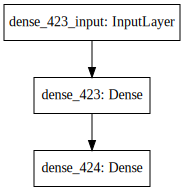

In [21]:
SVG(model_to_dot(bestModel).create(prog='dot', format='svg'))

<h3>Plot of RMSE per epoch, for Training Set and Validation Set</h3>
Note: Validation set is not the same as Test Set; it's randomly generated from the Training Set

In [ ]:
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
ax.set_title('RMSE per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
trainigSet, = ax.plot(np.sqrt(bestFitHistory.history['loss']), 'b', label = 'trainig set')
validationSet, = ax.plot(np.sqrt(bestFitHistory.history['val_loss']), 'r', label = 'validation set')
plt.legend(handles=[trainigSet, validationSet], labels=['training set', 'validation set'], prop={'size': 15})
#fig.savefig('{}/{}.{}'.format(saveFigDir, 'RMSE_per_epoch_ANNi40h5o1', 'pdf'), bbox_inches='tight')

<h3>Plot of predictions made using the Test Set</h3>

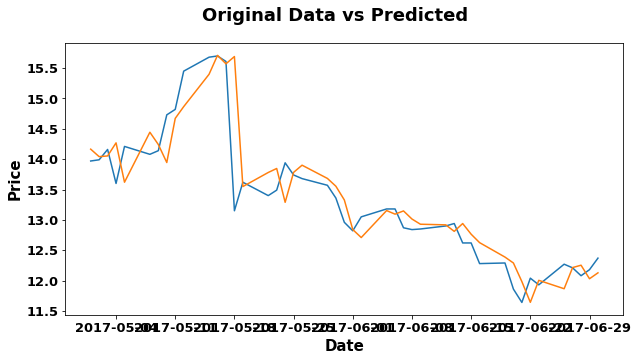

In [13]:
predictions = bestModel.predict(xTest)
predictions = yScaler.inverse_transform(predictions)
predictions_clean = []
for p in predictions:
    predictions_clean.extend(p)
predictionsSeries = pd.Series(predictions_clean, index = df['2017'].index)

plotSeries([df['PETR4_Close_trend']+ df['PETR4_Close_resid'], 
#            df['PETR4_Close_trend'],
            df['PETR4_Close_trend'] + predictionsSeries],
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Original Data vs Predicted', ylabel = 'Price')

<h3>Plot of errors from Trend Prediction and Trend + ANN Prediction</h3>

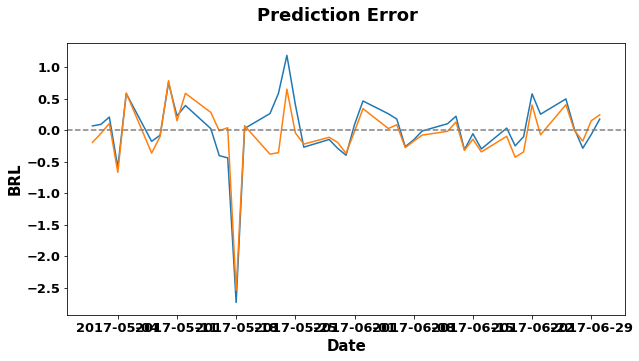

In [14]:
plotSeries([df['PETR4_Close_resid'], (df['PETR4_Close_resid'] - predictionsSeries)],
           plotZeroLine = True,
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Prediction Error', ylabel = 'BRL')

<h3>Retraining same topologies, but using standardization as scalling method</h3>

In [22]:
from sklearn.preprocessing import StandardScaler

xTrain, yTrain, xTest, yTest = prepData(df = df, 
                                        columnsToUse = columnsToUse, columnToPredict = 'PETR4_Close_resid', 
                                        nDelays = 10, testSetSize = len(df['2017']))

xStdScaler = StandardScaler()
xStdScaler.fit(xTrain)

yStdScaler = StandardScaler()
yStdScaler.fit(yTrain)

xTrain = xStdScaler.transform(xTrain)
xTest  = xStdScaler.transform(xTest)

yTrain = yStdScaler.transform(yTrain)

In [23]:
modelCheckpointStd = ModelCheckpoint('tmp/PETR4_MLP_std.h5', save_best_only=True)

init_time = time.time()

bestStdValLoss = np.Inf
bestStdFitHistory = None

for nNeurons in range(1, maxNeuronsInHiddenLayer + 1):
    for fold in range(nFolds):
        modelStd = Sequential([Dense(nNeurons, activation = 'tanh', input_dim = inputDim),
                               Dense(1, activation = 'linear')
                              ])
        modelStd.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mae'])

        fitHistory = modelStd.fit(xTrain, 
                                  yTrain, 
                                  epochs = 500,
                                  verbose = 0,
                                  shuffle = True,
                                  validation_split = 0.15, 
                                  callbacks = [modelCheckpointStd,
                                               earlyStopping])
        
        if min(fitHistory.history['val_loss']) < bestStdValLoss:
            bestStdValLoss = min(fitHistory.history['val_loss'])
            bestStdFitHistory = fitHistory

end_time = time.time()

print 'Time to fit all models: '+str(end_time-init_time)+' seconds'

Time to fit all models: 7159.58967209 seconds


In [24]:
bestModelStd = load_model('tmp/PETR4_MLP_std.h5')
bestModelStd.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_889 (Dense)            (None, 5)                 205       
_________________________________________________________________
dense_890 (Dense)            (None, 1)                 6         
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________


In [ ]:
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
ax.set_title('RMSE per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
trainigSet, = ax.plot(np.sqrt(bestStdFitHistory.history['loss']), 'b', label = 'trainig set')
validationSet, = ax.plot(np.sqrt(bestStdFitHistory.history['val_loss']), 'r', label = 'validation set')
plt.legend(handles=[trainigSet, validationSet], labels=['training set', 'validation set'], prop={'size': 15})
#fig.savefig('{}/{}.{}'.format(saveFigDir, 'RMSE_per_epoch_ANNi40h5o1', 'pdf'), bbox_inches='tight')

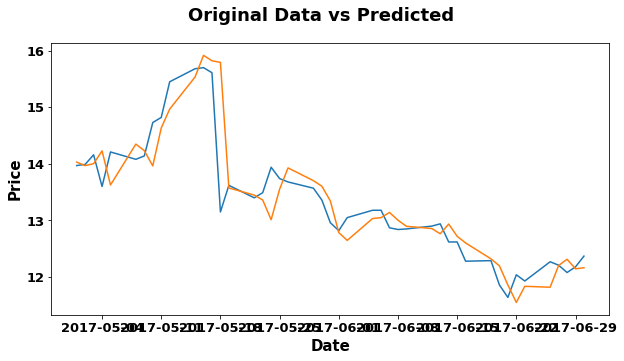

In [28]:
predictionsStd = bestModelStd.predict(xTest)
predictionsStd = yStdScaler.inverse_transform(predictions)
predictionsStd_clean = []
for p in predictionsStd:
    predictionsStd_clean.extend(p)
predictionsStdSeries = pd.Series(predictionsStd_clean, index = df['2017'].index)

plotSeries([df['PETR4_Close_trend']+ df['PETR4_Close_resid'], 
#            df['PETR4_Close_trend'],
            df['PETR4_Close_trend'] + predictionsStdSeries],
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Original Data vs Predicted', ylabel = 'Price')

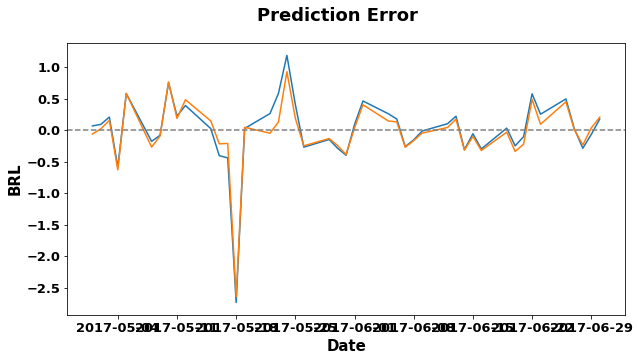

In [26]:
plotSeries([df['PETR4_Close_resid'], (df['PETR4_Close_resid'] - predictionsStdSeries)],
           plotZeroLine = True,
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Prediction Error', ylabel = 'BRL')